# Geometric factor calculations using Monte Carlo simulation data 
By Andrei R. Hanu - <andrei.hanu@nasa.gov>

## Introduction

The geometric factor ($\bf{G}$, units of cm$^2$ sr) of a particle detector is analogous to the "collecting power" of an optical telescope and is a function of the surface area of the instrument and detection efficiency, which itself is a function of the charge, mass, and energy of the incident particles. If the detector's geometry factor is known, the spatial differential flux ($\bf{\Phi}$, units of particles cm$^{-2}$ sr$^{-1}$ sec$^{-1}$) incident on the detector can be calculated from the counting rate ($\bf{N_D}$, units of particles $sec^{-1}$). So very simply, the geometric factor is defined as the counts received by a detector per unit time divided by the spatial differential flux around the instrument.

$$ G = \frac{N_D}{J} $$

** Note: For radiation risk assesment calculations, the flux is typically measured in energy bins with units of particles cm$^{-2}$ sr$^{-1}$ sec$^{-1}$ MeV$^{-1}$ **

Tradiationally, a detector's geometric factor has usually been estimated by approximation, however, only a few analytical solutions exist for simple source and detector geometries - see Sullivan (1971). For more complicated detector geometries, including electronic coincidence/anti-coincidence logic, an analytical solution might be difficult, or even impossible, to derive in the closed form. In such cases, the Monte Carlo technique is employed to compute the geometrical factor, see Crannell et al. (1971), by surrounded the detector geometry with a spherical source and assuming an isotropic radiation environment. Although, you can also apply this technique to anisotropic radiation environments. 

## Isotropic Radiation



## Source Normalization

For isotropic radiation environments, the number of particles $\bf{N_R}$ traversing a sphere is determined by the integrating the spatial differential flux over the surface area of the sphere and solid angle.

$$ N_R = \int_{\Omega}\int_{S} JdSd\Omega $$

Where the differential surface area ($\bf{dS}$) and differential solid angle ($\bf{d\Omega}$) in spherical coordinates is:

$$ dS = R^2 sin \theta d\theta d\phi $$

$$ d\Omega = sin \theta d\theta d\phi $$

Working through the integral, we see that the number of particles $\bf{N_R}$ traversing a sphere is:

$$ N_R = 4 \pi^2 R^2 J $$

And it depends on:

- The radius (ie. bigger sphere == more particles crossing the sphere)
- The spatial differential flux (ie. more flux == more particles crossing the sphere)

Finally, by using Eq.1 and Eq. 5 the geometric factor for an isotropic radiation environments can be written as follows:

$$ G = \frac{N_D}{N_R}4 \pi^2 R^2 $$

Where:

- $N_D$ is the number of particles interacting with the detector model
- $N_R$ is the total number of simulated particles
- $R$ is the radius of the spherical source encircling the detector model

The associated standard deviation ($\bf{\sigma_G}$) is obtained from the binomial distribution and follows:

$$ \sigma_G = 4\pi^2R^2 \sqrt{\left(1-\frac{N_D}{N_R}\right)\frac{N_D}{N_R^2}} $$

## Monte Carlo method

To calculate the geometric factor of a detector using the Monte Carlo method, the following steps need to be taken:

- The detector geometry, or a simplified model, should be implemented in your favourite Monte Carlo particle transport  code (Geant4, MCNP, FLUKA, EGS, etc)

If an isotropic flux, typical of space-borne instruments, is assumed:

- The detector geometry is enveloped by a spherical source such that the spectral, spatial, and angular distribution of primary particles can be specified

- The primary particles must be uniformly distributed over the entire surface of spherical source
- The angular distribution for the emission of primary particles must follow a cosine-law distribution

## References

+ Sullivan, J. D. "Geometric factor and directional response of single and multi-element particle telescopes." Nuclear Instruments and methods 95.1 (1971): 5-11.

+ Crannell, C. J., and J. F. Ormes. "Geometrical-factor determination using a monte carlo approach." Nuclear Instruments and Methods 94.1 (1971): 179-183.

+ Sanderson, T. R., and D. E. Page. "Geometrical aspects of the performance of cosmic ray detector telescopes in non-isotropic particle distributions." Nuclear Instruments and Methods 104.3 (1972): 493-504.


In [1]:
# Matplotlib - 2D plotting library
from matplotlib import pyplot as plt
from matplotlib import rcParams

# Show matplotlib figures inline the notebook
%matplotlib inline

# Pandas - High-performance data analysis
import pandas

# Glob - Unix style pathname pattern expansion
# Used to aggregate folders and files into a single list so they can be iterated over
import glob

# Numpy - For handling of large, multi-dimensional arrays and matrices
import numpy as np

# Scipy - For accurate integration
from scipy.integrate import simps
from scipy.integrate import trapz
import scipy.odr as sc

##########################################################################################
# Setting rcParams for publication quality graphs
fig_width_pt = 246.0                    # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0      # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # Width in inches
fig_height = fig_width*golden_mean      # Height in inches
fig_size =  [fig_width, fig_height]
fig_size =  [7.3,4.2]
# fig_size =  [7.3*1.5,4.2*1.5]
# fig_size =  [7.3*2,4.2*2]
params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'legend.fontsize': 9,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'xtick.major.size': 6,
        'xtick.major.width': 1,
        'xtick.minor.size': 2.5,
        'xtick.minor.width': 1,
        'ytick.major.size': 6,
        'ytick.major.width': 1,
        'ytick.minor.size': 2.5,
        'ytick.minor.width': 1,
        'font.family': 'times-new-roman',
        'font.sans-serif': 'Times New Roman',
        'font.size': 10,
        'text.usetex': True,
        'figure.figsize': fig_size}

# Update rcParams
rcParams.update(params)

In [2]:
##########################################################################################
# Energy of incident (input) particles
InputEnergies = np.array([np.linspace(100,900, num=9, endpoint=True, dtype = int),
                          np.linspace(1100,1900, num=9, endpoint=True, dtype = int),
                          np.linspace(1000,9000, num=9, endpoint=True, dtype = int),
                          np.linspace(10000,90000, num=9, endpoint=True, dtype = int),
                          np.linspace(100000,900000, num=9, endpoint=True, dtype = int),
                            ]).flatten()

# Folder containing simulation data
DataFolder = '../G4AdEPTCubeSat_Results/Gammas/'

# Arrange the array into the proper order
InputEnergies = np.delete(InputEnergies,18)
InputEnergies = np.insert(InputEnergies, [9], [1000])
InputEnergies = np.insert(InputEnergies, [45], [1000000])
##########################################################################################
# Energy thresholds (in eV) for events that will be included in the analysis
Thr_Gas = 100.
print InputEnergies

[    100     200     300     400     500     600     700     800     900
    1000    1100    1200    1300    1400    1500    1600    1700    1800
    1900    2000    3000    4000    5000    6000    7000    8000    9000
   10000   20000   30000   40000   50000   60000   70000   80000   90000
  100000  200000  300000  400000  500000  600000  700000  800000  900000
 1000000]


In [3]:
##########################################################################################
# Load the simulation data for each input energy
Data = []

for InputEnergy in InputEnergies:
    # Create data file template from current energy 
    DataFilename = 'gamma_' + str(InputEnergy) + 'keV_Nr_100000000_ISO_nt_G4AdEPTCubeSat_t[0-7].csv'

    # Statistics variables for each input energy data
    nPos = 0
    nElec = 0
    nSubPos = 0
    nSubElec = 0
    nTotal = 0
    nSubThr = 0
    nCompton = 0
    nPair = 0
    nPhoto = 0
    nTriton = 0
    
    # Print energy 
    print '\n------------------------------------------------------------'
    print 'Energy: \t\t', str(InputEnergy), 'keV'

    ##########################################################################################
    # Process the simulation data files
    # Column 0 - Total energy deposited in the sensitive gas volume [eV]
    # Column 1 - Energy deposited by positrons in the sensitive gas volume [eV]
    # Column 2 - Energy deposited by positrons in the sensitive gas volume [eV]
    # Column 3 - Energy deposited by tritons in the sensitive gas volume [eV]
    # Column 4 - Track length of particles in the sensitive gas volume [mm]
    # Column 5 - Number of secondary electrons generated in the sensitive gas volume
    # Column 6 - Number of secondary photons generated in the sensitive gas volume
    # Column 7 - Number of secondary positrons generated in the sensitive gas volume
    # Column 8 - Number of secondary tritons generated in the sensitive gas volume
    for dataFile in glob.glob(DataFolder + DataFilename):
        # Readout CSV files
        try:
            dataFrame = pandas.read_csv(dataFile, usecols=[0,1,2,3,4,5,6,7,8], comment="#", error_bad_lines=False, skip_blank_lines=True).values

            # Determine the interaction type
            for i in range(1,len(dataFrame)):
                if dataFrame[i,0] > Thr_Gas:
    #                 if dataFrame[i,8] > 0:
    #                     nTriton += 1
                    if dataFrame[i,7] > 0 and dataFrame[i,5] > 0:
                        nPair += 1
                    else:
                        if dataFrame[i,6] > 0. and dataFrame[i,5] > 0.:
                            nCompton += 1
                        else:
                            nPhoto += 1

            # Increment statistics
            nPos += dataFrame[(dataFrame[:,1] > Thr_Gas),0].size
            nElec += dataFrame[(dataFrame[:,2] > Thr_Gas),0].size
            nSubPos += dataFrame[(dataFrame[:,1] <= Thr_Gas),0].size
            nSubElec += dataFrame[(dataFrame[:,2] <= Thr_Gas),0].size
            nTotal += dataFrame[(dataFrame[:,0] > Thr_Gas),0].size
            nSubThr += dataFrame[(dataFrame[:,0] <= Thr_Gas),0].size
            
        except:
            pass
        
    # Add statistics to data list (Convert to numpy array later)
    Data.append([InputEnergy,nPos,nElec,nSubPos,nSubElec,nTotal,nSubThr,nCompton,nPair,nPhoto,nTriton])
        
    # Print statistics
    print '------------------------------------------------------------'
    print 'Number of events above threshold: \t', nTotal
    print 'Number of events below threshold: \t', nSubThr
    print 'Number of Compton Scattering events: \t', nCompton
    print 'Number of Pair Production events: \t', nPair
    print 'Number of Photoelectric Effect events: \t', nPhoto
    print '------------------------------------------------------------'
    
# Convert statistics list to Numpy array
Data = np.asarray(Data)


------------------------------------------------------------
Energy: 		100 keV
------------------------------------------------------------
Number of events above threshold: 	104487
Number of events below threshold: 	421
Number of Compton Scattering events: 	415
Number of Pair Production events: 	0
Number of Photoelectric Effect events: 	104064
------------------------------------------------------------

------------------------------------------------------------
Energy: 		200 keV
------------------------------------------------------------
Number of events above threshold: 	76859
Number of events below threshold: 	194
Number of Compton Scattering events: 	406
Number of Pair Production events: 	0
Number of Photoelectric Effect events: 	76445
------------------------------------------------------------

------------------------------------------------------------
Energy: 		300 keV
------------------------------------------------------------
Number of events above threshold: 	87460
Nu

In [154]:
##########################################################################################
# Calculate the geometry factor (G) assuming an isotropic radiation environment.
# The detector is centered on, and encircled by, a spherical source of radius (R) and
# with N_R simulated particles distributed uniformly along the inner surface.
# Everything with the suffix _2 is from the group which had 1 000 000 000 photons

# Source information (Get this from the Geant4 simulation!!)
N_R = 100000000.
N_R_2 = 1000000000.
R = 10.

# Calculate the geometry factors
G_Pair_1 = Data[0:10,8]/N_R*4*(np.pi**2)*(R**2)
G_Total_1 = Data[0:10,5]/N_R*4*(np.pi**2)*(R**2)

G_Pair_2 = Data[10:19,8]/N_R_2*4*(np.pi**2)*(R**2)
G_Total_2 = Data[10:19,5]/N_R_2*4*(np.pi**2)*(R**2)

G_Pair_3 = Data[19:,8]/N_R*4*(np.pi**2)*(R**2)
G_Total_3 = Data[19:,5]/N_R*4*(np.pi**2)*(R**2)

G_Pair = np.ndarray([])
G_Pair_temp = np.ndarray([])
G_Pair_temp = np.append(G_Pair_1,G_Pair_2)
G_Pair = np.append(G_Pair_temp,G_Pair_3)

G_Total = np.ndarray([])
G_Total_temp = np.ndarray([])
G_Total_temp = np.append(G_Total_1,G_Total_2)
G_Total = np.append(G_Total_temp,G_Total_3)

# Calculate the errors for geometry factors 
err_G_Pair_1 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[0:10,8]/N_R)*Data[0:10,8]/N_R**2)
err_G_Total_1 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[0:10,5]/N_R)*Data[0:10,5]/N_R**2)

err_G_Pair_2 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[10:19,8]/N_R_2)*Data[10:19,8]/N_R_2**2)
err_G_Total_2 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[10:19,5]/N_R_2)*Data[10:19,5]/N_R_2**2)

err_G_Pair_3 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[19:,8]/N_R)*Data[19:,8]/N_R**2)
err_G_Total_3 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[19:,5]/N_R)*Data[19:,5]/N_R**2)


err_G_Pair = np.array([])
err_G_Pair_temp = np.array([])
err_G_Pair_temp = np.append(err_G_Pair_1,err_G_Pair_2)
err_G_Pair = np.append(err_G_Pair_temp,err_G_Pair_3)

err_G_Total = np.array([])
err_G_Total_temp = np.array([])
err_G_Total_temp = np.append(err_G_Pair_1,err_G_Pair_2)
err_G_Total = np.append(err_G_Total_temp,err_G_Total_3)

# Calculate relative errors for the geometry factors
relErr_G_Total = err_G_Total/G_Total
relErr_G_Pair = err_G_Pair/G_Pair

npFit = np.polyfit(InputEnergies, G_Pair, 4)
def F(a,x):
    Z = 18
    re = 2.8179e-15
    Na = 6.022e23
    A = 39.95
#     y = A/(a*Na)*(1.-(4./3.)*0.5*(1.-0.5))
#     Y = simps(y,Data[10:,0])
#     return y
#     return a[0]*(1-np.exp(-a[1]*np.log(x)))
    return a[0]*(1-x**(-a[1]))
 
fit = sc.Model(F)
myData = sc.Data(Data[:,0], G_Pair)#, we=0.0001, wd=err_G_Pair)
myOdr = sc.ODR(myData, fit, [1e3,1e-3], maxit=1000000)
myOutput = myOdr.run()
myOutput.pprint()
beta = myOutput.beta#np.array([1e5, 1e-6])#
# print beta
# print F(beta, (Data[:,0]/1000.))
# print G_Pair

Beta: [  2.48592724e+03   1.35792908e-05]
Beta Std Error: [  2.55709907e+06   1.39686709e-02]
Beta Covariance: [[  1.47324950e+14  -8.04792341e+05]
 [ -8.04792341e+05   4.39634098e-03]]
Residual Variance: 0.0443832197462
Inverse Condition #: 5.10984939849e-07
Reason(s) for Halting:
  Sum of squares convergence


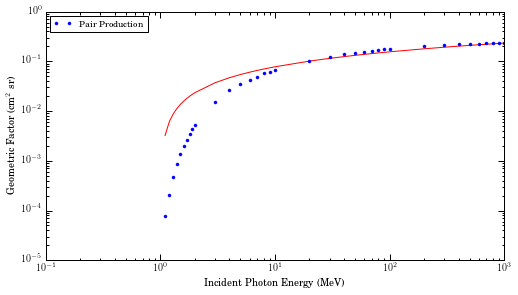

In [155]:
##########################################################################################
# Plot the Geometry Factor over a range of particle energies
figG, axG = plt.subplots(1,1)
# G_Func = sc.polynomial(G_Pair)

# plt.loglog(Data[:,0]/1000., G_Total, 'k.-', linewidth=0.75, label="Total")
# plt.loglog(Data[:,0]/1000., y, 'r')
plt.loglog(Data[:,0]/1000., F(beta, (Data[:,0]/1000.)), 'r')
plt.loglog(Data[:,0]/1000., G_Pair/np.pi, 'b.', linewidth=0.75, label="Pair Production")
# plt.loglog(Data[:,0]/1000., G_Func, 'r-', linewidth=0.75, label="Pair Production")
# plt.errorbar(Data[0:10,0]/1000., G_Pair, xerr=0, yerr=err_G_Pair[0:10], fmt='.')

# Figure Properties
axG.set_ylabel(r'Geometric Factor (cm$^2$ sr)')  
axG.set_xlabel('Incident Photon Energy (MeV)') 
# axG.set_ylim(0.01, 2000.)
# axG.set_xlim(0.1, 1000)

axG.legend(loc='upper left')

# Tight Layout
plt.tight_layout()

# Save the figure 
# file_figG = 'Geometric_Factor_Gamma.pdf'
# plt.savefig(DataFolder + file_figG, bbox_inches="tight")
# print 'Plot saved to: ' + (DataFolder+file_figG)

# Show the figure
plt.show(figG)
# print max(G_Pair)
# print relErr_G_Pair

Plot saved to: ../G4AdEPTCubeSat_Results/Gammas/Gamma_Flux.pdf


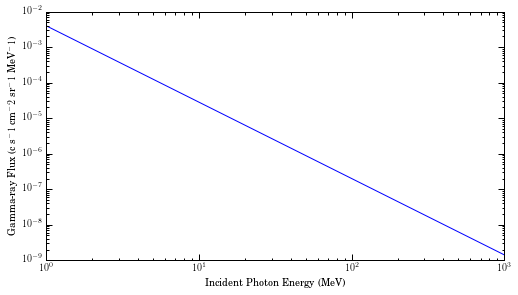

In [145]:
Energies_MeV = InputEnergies/1000.
ETFlux = 40.*10**(-4)*(Energies_MeV**(-2.15))

figF, axF = plt.subplots(1,1)

plt.loglog(Energies_MeV,ETFlux)

# Figure Properties
axF.set_ylabel(r'Gamma-ray Flux (c s$^-1$ cm$^-2$ sr$^-1$ MeV$^-1$)')  
axF.set_xlabel('Incident Photon Energy (MeV)') 
axF.set_ylim(10**-9, 10**-2)
axF.set_xlim(1, 1000)

# Tight Layout
plt.tight_layout()

# Save the figure 
file_figF = 'Gamma_Flux.pdf'
plt.savefig(DataFolder + file_figF, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_figF)

# Show the figure
plt.show(figF)

Plot saved to: ../G4AdEPTCubeSat_Results/Gammas/Counts_Energy.pdf


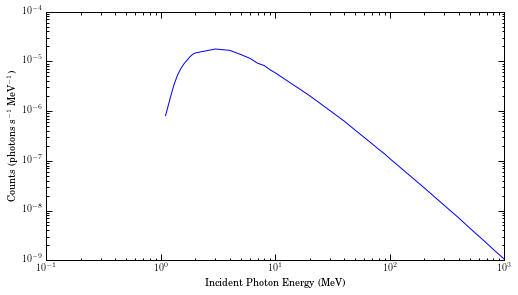

The detector will measure 0.000173925309279 counts/sec.
The detector will measure 0.966660867842 counts/orbit.


In [148]:
# Convolution of Geometry Factor with Flux
counts = G_Pair*ETFlux
counts_s = simps(counts)
counts_o = counts_s*60*92.6318

figC, axC = plt.subplots(1,1)
plt.loglog(Energies_MeV,counts)

# Figure Properties
axC.set_ylabel(r'Counts (photons s$^{-1}$ MeV$^{-1}$)')  
axC.set_xlabel('Incident Photon Energy (MeV)') 
# axC.set_ylim(0., 0.05)
axC.set_xlim(0.1, 1000)

axC.legend(loc='upper left')

# Tight Layout
plt.tight_layout()

# Save the figure 
file_figC = 'Counts_Energy.pdf'
plt.savefig(DataFolder + file_figC, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_figC)

# Show the figure
plt.show(figC)

print "The detector will measure", counts_s, "counts/sec."
print "The detector will measure", counts_o, "counts/orbit."

In [ ]:
# print G_Total
# print err_G_Total
# print G_Pair
# print err_G_Pair
# print relErr_G_Pair

Plot saved to: ../G4AdEPTCubeSat_Results/Gammas/Geometric_Factor_Error_Gamma.pdf


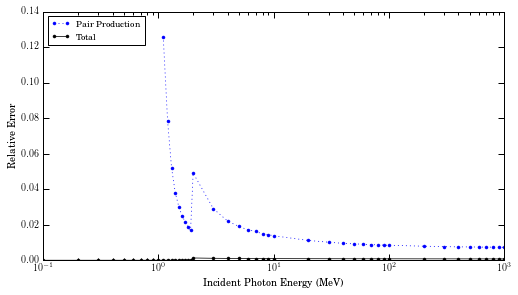

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.00023231  0.00033897  0.00047111
  0.00059357  0.00069657  0.00078541  0.00085671  0.00093377  0.00099524
  0.12670672  0.10984318  0.10255153  0.098793    0.09600385  0.09409072
  0.09251587  0.09132232  0.09030372  0.08611387  0.08449503  0.08341997
  0.08264583  0.08204417  0.08148964  0.08104432  0.08060695  0.0802775
  0.07812887  0.07710645  0.07643811  0.07594679  0.07569986  0.07534807
  0.07515372  0.07500918  0.07486271]
[         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
  12.59881537   7.85674138   5.18475751   3.79594677   3.02336862
   2.51896162   2.17958341   1.89490218   1.69248301   4.90879675
   2.89762068   2.19367717   1.90240754   1.7064454    1.619628     1.4800272
   1.43974598   1.37878232   1.11354361   1.01451273   0.95043357
   0.92361763   0.89873227   0.87896422 

In [149]:
##########################################################################################
# Plot the error in the Geometry Factor over a range of particle energies
figE, axE = plt.subplots(1,1)

plt.plot(Data[:,0]/1000., relErr_G_Pair, 'b.:', linewidth=0.75, label="Pair Production")
plt.semilogx(Data[:,0]/1000., relErr_G_Total, 'k.-', linewidth=0.75, label="Total")

# Figure Properties
axE.set_ylabel(r'Relative Error')  
axE.set_xlabel('Incident Photon Energy (MeV)') 
# axE.set_ylim(0., 0.05)
# axE.set_xlim(0.1, 1001)

axE.legend(loc='upper left')

# Tight Layout
plt.tight_layout()

# Save the figure 
file_figE = 'Geometric_Factor_Error_Gamma.pdf'
plt.savefig(DataFolder + file_figE, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_figE)

# Show the figure
plt.show(figE)
print relErr_G_Total*100.
print relErr_G_Pair*100.